# 데이터 로드

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
def load_dataset(csv_path, TRAIN_RATIO=0.8):
    
    global X, y, X_train, X_test, y_train, y_test, df
    
    # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 성별 원핫 인코딩
    df=pd.get_dummies(df,columns=['Sex'])
    
    # 학습 데이터 분리
    X = df.drop('Rings', axis=1)
    y = df['Rings']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    return X_train, X_test, y_train, y_test

csv_path = '../colabo/Data/Regression_data.csv'
X_train, X_test, y_train, y_test = load_dataset(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3341, 10) (836, 10) (3341,) (836,)


In [2]:
# 사용자 정의 평가 지표 클래스
import tensorflow as tf

class EvalAccuracy(tf.keras.metrics.Metric): # TensorFlow의 Metric 클래스를 상속 받음

    def __init__(self, name="eval_accuracy", **kwargs): # 부모 클래스의 __init__() 메소드를 호출하여 필요한 초기화를 수행
        super(EvalAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name="ctp", initializer="zeros")
        # add_weight() 메소드를 사용하여 평가 지표를 계산하는데 필요한 변수를 생성(각 배치에서의 평가 결과를 누적하기 위해)
        # add_weight() 는 텐서플로우 Layer 클래스의 메서드(새로운 가중치를 추가하는 기능, 여기서는 평가 지표를 계산하는 데 사용되는 일종의 내부 변수를 의미)
        # 이 구문이 실행되면, EvalAccuracy 인스턴스는 새로운 가중치를 추가하고 그 가중치를 self.correct에 저장한다.
        # 이 self.correct는 update_state() 메서드에서 업데이트되며, '현재까지 처리한 모든 배치에 대한 평가 지표의 평균을 저장'한다.

    def update_state(self, y_true, y_predict, sample_weight=None):
        value = tf.abs((y_predict - y_true) / y_true)
        self.correct.assign(tf.reduce_mean(value)) # 오차율을 계산해서 correct 변수에 누적한 후, assign() 메소드를 사용하여 correct 변수의 값을 업데이트

    def result(self):
        return 1 - self.correct

    def reset_states(self):
        # 에포크마다 평가 지표 초기화
        self.correct.assign(0.)

In [3]:
# 베이스모델
import numpy as np

def Base_Model(LEARNING_RATE=0.01):
    
    np.random.seed(42)
    tf.random.set_seed(42)
    
    global X, y, X_train, X_test, y_train, y_test, df
    
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    
    model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=128, activation='relu', input_shape=(len(X_train.keys()),)),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=1)
        ])
    
    # 옵티마이저와 손실 함수 설정
    optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE) # SGD : 경사하강법을 기본적으로 사용하는 옵티마이저
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=[EvalAccuracy()])
    
    return model

model = Base_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [4]:
# 하이퍼파라미터 세팅
LEARNING_RATE = 0.01
EPOCHS = 100
MB_SIZE = 100
REPORT = 1
TRAIN_RATIO = 0.8

history = model.fit(
  X_train, y_train,
  batch_size=MB_SIZE,
  validation_split = 0.2,
  verbose=1,
  epochs=EPOCHS)

Epoch 1/100
27/27 [==============================] - 1s 14ms/step - loss: 21.5847 - eval_accuracy: 0.8752 - val_loss: 6.8777 - val_eval_accuracy: 0.8268
Epoch 2/100
20/27 [=====================>........] - ETA: 0s - loss: 7.5362 - eval_accuracy: 0.8234

c:\Users\k10dh\anaconda3\envs\TeamProject\lib\site-packages\keras\engine\training.py:2448: UserWarning: Metric EvalAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


27/27 [==============================] - 0s 5ms/step - loss: 7.5373 - eval_accuracy: 0.7447 - val_loss: 7.3875 - val_eval_accuracy: 0.8384
Epoch 3/100
27/27 [==============================] - 0s 4ms/step - loss: 7.4378 - eval_accuracy: 0.8278 - val_loss: 7.1645 - val_eval_accuracy: 0.7690
Epoch 4/100
27/27 [==============================] - 0s 5ms/step - loss: 7.3196 - eval_accuracy: 0.7632 - val_loss: 7.4337 - val_eval_accuracy: 0.8409
Epoch 5/100
27/27 [==============================] - 0s 4ms/step - loss: 7.2266 - eval_accuracy: 0.7722 - val_loss: 6.1114 - val_eval_accuracy: 0.8321
Epoch 6/100
27/27 [==============================] - 0s 4ms/step - loss: 6.9079 - eval_accuracy: 0.7638 - val_loss: 7.0750 - val_eval_accuracy: 0.8447
Epoch 7/100
27/27 [==============================] - 0s 5ms/step - loss: 7.1258 - eval_accuracy: 0.7780 - val_loss: 7.6223 - val_eval_accuracy: 0.8430
Epoch 8/100
27/27 [==============================] - 0s 4ms/step - loss: 6.6623 - eval_accuracy: 0.7741 - 

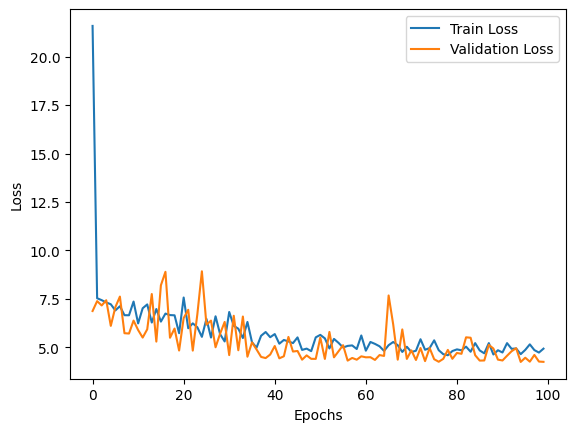

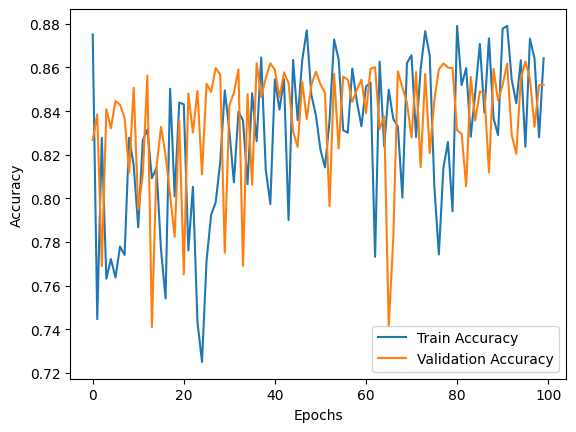

27/27 [==============================] - 0s 2ms/step - loss: 4.2559 - eval_accuracy: 0.7079
Test Loss: 4.256
Test Accuracy: 0.708


c:\Users\k10dh\anaconda3\envs\TeamProject\lib\site-packages\keras\engine\training.py:2448: UserWarning: Metric EvalAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


In [5]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련 및 검증 평가 지표 추출
train_accuracy = history.history['eval_accuracy']
val_accuracy = history.history['val_eval_accuracy']

# 평가 지표 그래프 그리기
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 테스트 세트 평가
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", round(loss, 3))
print("Test Accuracy:", round(accuracy, 3))


In [9]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Please install GPU version of TF
